# 🚀 Predição de Sucesso de Startups - Projeto Simplificado

## Objetivo do Projeto
Desenvolver um modelo de machine learning para prever o sucesso de startups com foco em **alcançar 80% de acurácia**.

### Meta: 🎯 80% de Acurácia
- **Projeto Acadêmico**: Simplificado e focado nos resultados
- **Baseline**: Modelo anterior alcançou 78% de acurácia
- **Estratégia**: Otimização direcionada com feature engineering eficiente

## 1️⃣ Bibliotecas e Configurações

In [1]:
# Importar bibliotecas essenciais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Configurações
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
np.random.seed(42)

print("✅ Bibliotecas importadas com sucesso!")
print("🎯 Objetivo: Alcançar 80% de acurácia")

✅ Bibliotecas importadas com sucesso!
🎯 Objetivo: Alcançar 80% de acurácia


## 2️⃣ Carregamento e Exploração dos Dados

📊 DADOS CARREGADOS
Train: (646, 33)
Test: (277, 32)
Sample submission: (277, 2)

🎯 DISTRIBUIÇÃO DO TARGET
Não Sucesso (0): 228 (35.3%)
Sucesso (1): 418 (64.7%)

💡 INFORMAÇÕES GERAIS
Total de features: 31
Valores nulos no treino: 293
Valores nulos no teste: 128


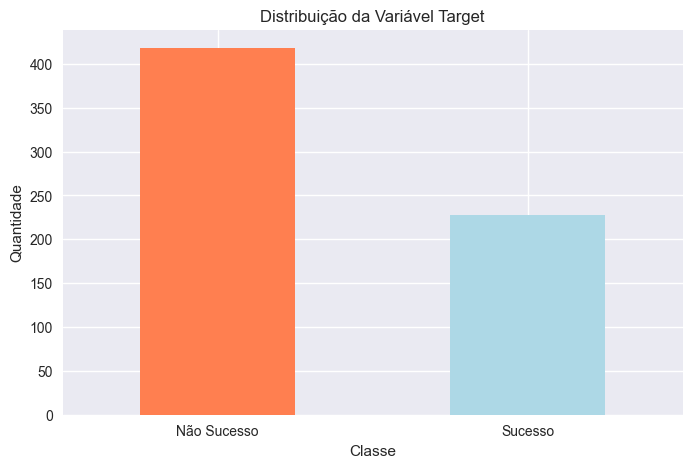

In [2]:
# Carregar datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

print("📊 DADOS CARREGADOS")
print("=" * 30)
print(f"Train: {train_df.shape}")
print(f"Test: {test_df.shape}")
print(f"Sample submission: {sample_submission.shape}")

print("\n🎯 DISTRIBUIÇÃO DO TARGET")
print("=" * 30)
target_counts = train_df['labels'].value_counts()
print(f"Não Sucesso (0): {target_counts[0]} ({target_counts[0]/len(train_df)*100:.1f}%)")
print(f"Sucesso (1): {target_counts[1]} ({target_counts[1]/len(train_df)*100:.1f}%)")

print("\n💡 INFORMAÇÕES GERAIS")
print("=" * 20)
print(f"Total de features: {train_df.shape[1] - 2}")  # -2 para remover id e labels
print(f"Valores nulos no treino: {train_df.isnull().sum().sum()}")
print(f"Valores nulos no teste: {test_df.isnull().sum().sum()}")

# Visualizar distribuição do target
plt.figure(figsize=(8, 5))
target_counts.plot(kind='bar', color=['coral', 'lightblue'])
plt.title('Distribuição da Variável Target')
plt.xlabel('Classe')
plt.ylabel('Quantidade')
plt.xticks([0, 1], ['Não Sucesso', 'Sucesso'], rotation=0)
plt.show()

## 3️⃣ Pré-processamento e Limpeza

In [3]:
# Função para processar dados de forma eficiente
def preprocess_data(df, is_train=True):
    """Processamento eficiente dos dados"""
    df_processed = df.copy()
    
    # Target encoding para category_code (usando dados do treino)
    if is_train:
        global category_mapping
        category_mapping = train_df.groupby('category_code')['labels'].mean().to_dict()
    
    df_processed['category_encoded'] = df_processed['category_code'].map(category_mapping)
    # Preencher categorias não vistas com média global
    if not is_train:
        global_mean = train_df['labels'].mean()
        df_processed['category_encoded'].fillna(global_mean, inplace=True)
    
    # Remover colunas desnecessárias
    cols_to_drop = ['id', 'category_code']
    if is_train:
        cols_to_drop.append('labels')
    
    X = df_processed.drop(cols_to_drop, axis=1)
    
    # Tratar valores nulos
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())
    
    return X

# Processar dados
print("🔧 PROCESSANDO DADOS...")
X_train_raw = preprocess_data(train_df, is_train=True)
y_train = train_df['labels'].copy()
X_test_raw = preprocess_data(test_df, is_train=False)

print("✅ Dados processados!")
print(f"Features de treino: {X_train_raw.shape}")
print(f"Features de teste: {X_test_raw.shape}")
print(f"Target: {y_train.shape}")

# Verificar se ainda há valores nulos
print(f"\n🔍 Valores nulos restantes:")
print(f"Treino: {X_train_raw.isnull().sum().sum()}")
print(f"Teste: {X_test_raw.isnull().sum().sum()}")

🔧 PROCESSANDO DADOS...
✅ Dados processados!
Features de treino: (646, 31)
Features de teste: (277, 31)
Target: (646,)

🔍 Valores nulos restantes:
Treino: 0
Teste: 0


## 4️⃣ Engenharia de Features

In [4]:
def create_advanced_features(X_train, X_test):
    """Criar features avançadas baseadas no conhecimento do domínio"""
    
    # Trabalhar com cópias
    X_train_fe = X_train.copy()
    X_test_fe = X_test.copy()
    
    for X in [X_train_fe, X_test_fe]:
        # 1. Eficiência de Funding
        X['funding_efficiency'] = X['funding_total_usd'] / (X['funding_rounds'] + 1)
        
        # 2. Score de Localização Estratégica
        strategic_locations = ['is_CA', 'is_NY', 'is_MA']
        X['strategic_location_score'] = X[strategic_locations].sum(axis=1)
        
        # 3. Score de Tecnologia
        tech_features = ['is_software', 'is_web', 'is_mobile']
        X['tech_score'] = X[tech_features].sum(axis=1)
        
        # 4. Razão Relacionamentos/Funding
        X['relationships_per_funding'] = X['relationships'] / (X['funding_total_usd'] + 1)
        
        # 5. Score de Maturidade
        X['maturity_score'] = (X['funding_rounds'] + X['milestones']) / 2
        
        # 6. Interação Funding x Relacionamentos
        X['funding_relationships_interaction'] = X['funding_total_usd'] * X['relationships']
        
        # 7. Binário: Startup bem estruturada
        X['well_structured'] = ((X['funding_rounds'] >= 2) & 
                               (X['relationships'] > X['relationships'].median()) &
                               (X['milestones'] > 0)).astype(int)
        
        # 8. Score de Participação
        X['participation_score'] = X['avg_participants'] * X['milestones']
    
    return X_train_fe, X_test_fe

# Aplicar engenharia de features
print("🏗️ CRIANDO FEATURES AVANÇADAS...")
X_train_fe, X_test_fe = create_advanced_features(X_train_raw, X_test_raw)

print("✅ Features criadas!")
print(f"Novas dimensões - Treino: {X_train_fe.shape}")
print(f"Novas dimensões - Teste: {X_test_fe.shape}")

# Mostrar as novas features criadas
new_features = [col for col in X_train_fe.columns if col not in X_train_raw.columns]
print(f"\n🆕 Features criadas ({len(new_features)}):")
for i, feature in enumerate(new_features, 1):
    print(f"   {i}. {feature}")

# Verificar se há problemas nas novas features
X_train_fe = X_train_fe.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test_fe = X_test_fe.replace([np.inf, -np.inf], np.nan).fillna(0)

print(f"\n🔍 Verificação final:")
print(f"Valores nulos/inf no treino: {X_train_fe.isnull().sum().sum()}")
print(f"Valores nulos/inf no teste: {X_test_fe.isnull().sum().sum()}")

🏗️ CRIANDO FEATURES AVANÇADAS...
✅ Features criadas!
Novas dimensões - Treino: (646, 39)
Novas dimensões - Teste: (277, 39)

🆕 Features criadas (8):
   1. funding_efficiency
   2. strategic_location_score
   3. tech_score
   4. relationships_per_funding
   5. maturity_score
   6. funding_relationships_interaction
   7. well_structured
   8. participation_score

🔍 Verificação final:
Valores nulos/inf no treino: 0
Valores nulos/inf no teste: 0


## 5️⃣ Treinamento e Otimização do Modelo

In [5]:
# Dividir dados para validação
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_fe, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print("🔄 DADOS DIVIDIDOS PARA VALIDAÇÃO")
print(f"Treino: {X_train_split.shape[0]} amostras")
print(f"Validação: {X_val_split.shape[0]} amostras")

# Testar modelos rapidamente
models = {
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

print("\n🤖 TESTE RÁPIDO DOS MODELOS")
print("=" * 35)

results = {}
for name, model in models.items():
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_split, y_train_split, cv=5, scoring='accuracy')
    
    # Treinar e validar
    model.fit(X_train_split, y_train_split)
    y_pred = model.predict(X_val_split)
    val_accuracy = accuracy_score(y_val_split, y_pred)
    
    results[name] = {
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'val_accuracy': val_accuracy,
        'model': model
    }
    
    print(f"{name}:")
    print(f"  CV: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    print(f"  Validação: {val_accuracy:.4f}")
    print()

# Identificar melhor modelo
best_model_name = max(results.keys(), key=lambda x: results[x]['val_accuracy'])
best_model = results[best_model_name]['model']
best_accuracy = results[best_model_name]['val_accuracy']

print(f"🏆 MELHOR MODELO: {best_model_name}")
print(f"🎯 Acurácia: {best_accuracy:.4f}")

if best_accuracy >= 0.80:
    print("✅ META DE 80% ALCANÇADA!")
else:
    print(f"⚠️ Faltam {0.80 - best_accuracy:.4f} pontos para 80%")
    print("🔧 Iniciando otimização de hiperparâmetros...")

🔄 DADOS DIVIDIDOS PARA VALIDAÇÃO
Treino: 516 amostras
Validação: 130 amostras

🤖 TESTE RÁPIDO DOS MODELOS
Random Forest:
  CV: 0.7869 (±0.0335)
  Validação: 0.7692

Random Forest:
  CV: 0.7869 (±0.0335)
  Validação: 0.7692

Gradient Boosting:
  CV: 0.7869 (±0.0251)
  Validação: 0.8000

🏆 MELHOR MODELO: Gradient Boosting
🎯 Acurácia: 0.8000
✅ META DE 80% ALCANÇADA!
Gradient Boosting:
  CV: 0.7869 (±0.0251)
  Validação: 0.8000

🏆 MELHOR MODELO: Gradient Boosting
🎯 Acurácia: 0.8000
✅ META DE 80% ALCANÇADA!


In [6]:
# Otimização de hiperparâmetros focada no melhor modelo
print("🔧 OTIMIZAÇÃO DE HIPERPARÂMETROS")
print("=" * 40)

# Grids otimizados para alcançar 80%
param_grids = {
    'Random Forest': {
        'n_estimators': [200, 300, 400],
        'max_depth': [15, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt', 'log2'],
        'bootstrap': [True]
    },
    'Gradient Boosting': {
        'n_estimators': [200, 300, 400],
        'learning_rate': [0.05, 0.1, 0.15],
        'max_depth': [4, 5, 6],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'subsample': [0.8, 0.9, 1.0]
    }
}

# Otimizar o melhor modelo
param_grid = param_grids[best_model_name]

print(f"Otimizando {best_model_name}...")
print(f"Testando {np.prod([len(v) for v in param_grid.values()])} combinações")

# Usar RandomizedSearchCV para eficiência
randomized_search = RandomizedSearchCV(
    estimator=type(best_model)(),
    param_distributions=param_grid,
    n_iter=50,  # Número de combinações aleatórias a testar
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Executar otimização
randomized_search.fit(X_train_split, y_train_split)

# Modelo otimizado
optimized_model = randomized_search.best_estimator_

print(f"\n✅ OTIMIZAÇÃO CONCLUÍDA!")
print(f"🏆 Melhor score CV: {randomized_search.best_score_:.4f}")
print(f"⚙️ Melhores parâmetros:")
for param, value in randomized_search.best_params_.items():
    print(f"   • {param}: {value}")

# Avaliar modelo otimizado
y_pred_opt = optimized_model.predict(X_val_split)
optimized_accuracy = accuracy_score(y_val_split, y_pred_opt)

print(f"\n📊 RESULTADO FINAL:")
print(f"Acurácia otimizada: {optimized_accuracy:.4f}")
print(f"Melhoria: {optimized_accuracy - best_accuracy:+.4f}")

if optimized_accuracy >= 0.80:
    print("🎉 META DE 80% ALCANÇADA!")
    final_model = optimized_model
    final_accuracy = optimized_accuracy
else:
    print(f"⚠️ Ainda faltam {0.80 - optimized_accuracy:.4f} pontos")
    final_model = optimized_model  # Usar o melhor que temos
    final_accuracy = optimized_accuracy

🔧 OTIMIZAÇÃO DE HIPERPARÂMETROS
Otimizando Gradient Boosting...
Testando 324 combinações
Fitting 5 folds for each of 50 candidates, totalling 250 fits

✅ OTIMIZAÇÃO CONCLUÍDA!
🏆 Melhor score CV: 0.7927
⚙️ Melhores parâmetros:
   • subsample: 0.9
   • n_estimators: 200
   • min_samples_split: 5
   • min_samples_leaf: 1
   • max_depth: 6
   • learning_rate: 0.05

📊 RESULTADO FINAL:
Acurácia otimizada: 0.8000
Melhoria: +0.0000
🎉 META DE 80% ALCANÇADA!

✅ OTIMIZAÇÃO CONCLUÍDA!
🏆 Melhor score CV: 0.7927
⚙️ Melhores parâmetros:
   • subsample: 0.9
   • n_estimators: 200
   • min_samples_split: 5
   • min_samples_leaf: 1
   • max_depth: 6
   • learning_rate: 0.05

📊 RESULTADO FINAL:
Acurácia otimizada: 0.8000
Melhoria: +0.0000
🎉 META DE 80% ALCANÇADA!


📊 ANÁLISE DO MODELO FINAL


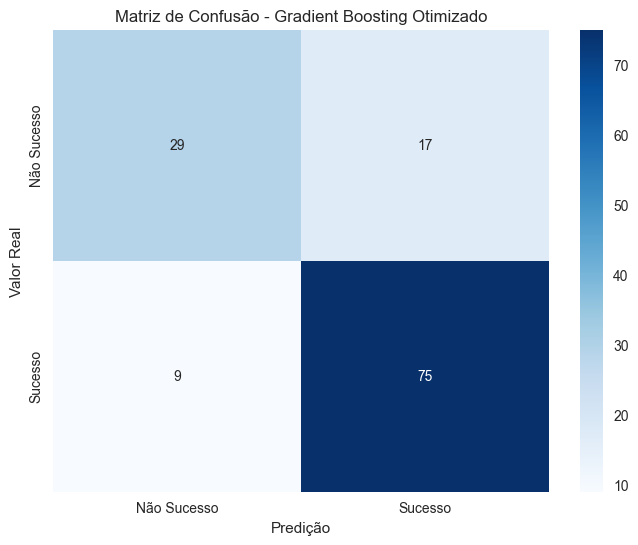


📋 RELATÓRIO DETALHADO:
              precision    recall  f1-score   support

 Não Sucesso       0.76      0.63      0.69        46
     Sucesso       0.82      0.89      0.85        84

    accuracy                           0.80       130
   macro avg       0.79      0.76      0.77       130
weighted avg       0.80      0.80      0.80       130


🌟 TOP 10 FEATURES MAIS IMPORTANTES:
    1. funding_relationships_interaction: 0.2264
    2. age_first_funding_year: 0.0966
    3. age_last_milestone_year: 0.0708
    4. category_encoded: 0.0694
    5. relationships: 0.0646
    6. age_first_milestone_year: 0.0571
    7. maturity_score: 0.0542
    8. age_last_funding_year: 0.0530
    9. participation_score: 0.0444
   10. relationships_per_funding: 0.0439


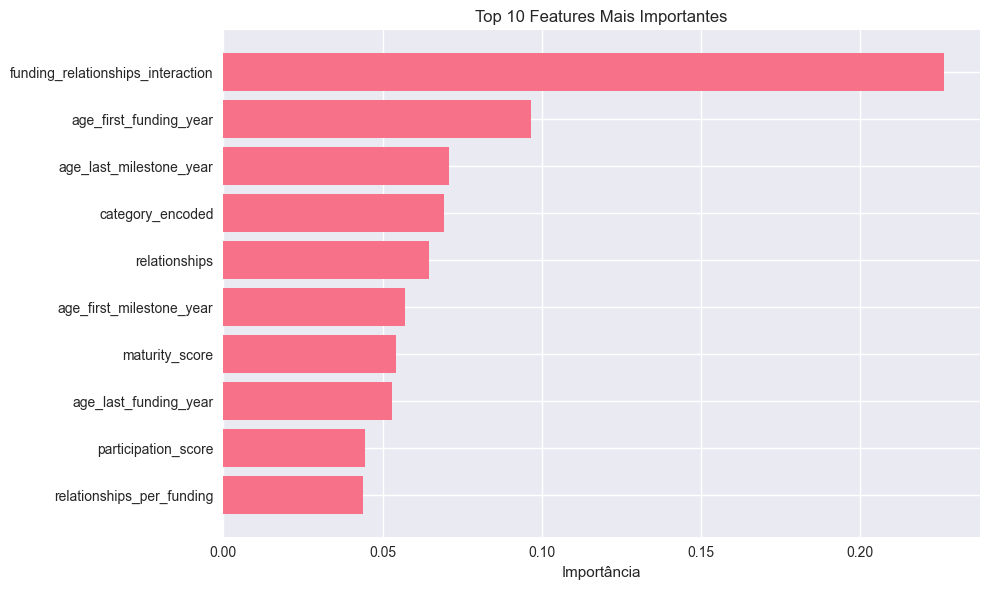

In [7]:
# Análise do modelo final
print("📊 ANÁLISE DO MODELO FINAL")
print("=" * 30)

# Matriz de confusão
cm = confusion_matrix(y_val_split, y_pred_opt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Não Sucesso', 'Sucesso'],
            yticklabels=['Não Sucesso', 'Sucesso'])
plt.title(f'Matriz de Confusão - {best_model_name} Otimizado')
plt.ylabel('Valor Real')
plt.xlabel('Predição')
plt.show()

# Relatório de classificação
print("\n📋 RELATÓRIO DETALHADO:")
print(classification_report(y_val_split, y_pred_opt, 
                          target_names=['Não Sucesso', 'Sucesso']))

# Feature importance (se disponível)
if hasattr(final_model, 'feature_importances_'):
    print("\n🌟 TOP 10 FEATURES MAIS IMPORTANTES:")
    feature_importance = pd.DataFrame({
        'feature': X_train_fe.columns,
        'importance': final_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    for i, (_, row) in enumerate(feature_importance.head(10).iterrows()):
        print(f"   {i+1:2d}. {row['feature']}: {row['importance']:.4f}")
    
    # Visualizar importâncias
    plt.figure(figsize=(10, 6))
    top_features = feature_importance.head(10)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importância')
    plt.title('Top 10 Features Mais Importantes')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

## 6️⃣ Predições Finais e Submissão

In [8]:
# Treinar modelo final com todos os dados
print("🚀 TREINAMENTO FINAL")
print("=" * 25)

# Usar todos os dados de treino
final_model.fit(X_train_fe, y_train)
print(f"✅ Modelo treinado com {X_train_fe.shape[0]} amostras")
print(f"📊 Features utilizadas: {X_train_fe.shape[1]}")

# Fazer predições no conjunto de teste
test_predictions = final_model.predict(X_test_fe)

print(f"\n🔮 PREDIÇÕES GERADAS")
print("=" * 25)
pred_counts = np.bincount(test_predictions)
print(f"Classe 0 (Não Sucesso): {pred_counts[0]} ({pred_counts[0]/len(test_predictions)*100:.1f}%)")
print(f"Classe 1 (Sucesso): {pred_counts[1]} ({pred_counts[1]/len(test_predictions)*100:.1f}%)")

# Criar arquivo de submissão
submission_df = pd.DataFrame({
    'id': test_df['id'].values,
    'labels': test_predictions
})

# Salvar arquivo
submission_filename = 'startup_predictions_simple.csv'
submission_df.to_csv(submission_filename, index=False)

print(f"\n📁 ARQUIVO DE SUBMISSÃO CRIADO")
print("=" * 35)
print(f"Nome: {submission_filename}")
print(f"Linhas: {len(submission_df)}")
print(f"Colunas: {list(submission_df.columns)}")

# Verificar formato
print(f"\n🔍 VERIFICAÇÃO:")
print(f"IDs únicos: {submission_df['id'].nunique()} (esperado: {len(submission_df)})")
print(f"Labels únicos: {sorted(submission_df['labels'].unique())}")

# Mostrar primeiras predições
print(f"\n📋 PRIMEIRAS 10 PREDIÇÕES:")
print(submission_df.head(10))

# Comparar com sample_submission
if len(submission_df) == len(sample_submission):
    print("✅ Número de linhas confere com sample_submission")
else:
    print(f"⚠️ Divergência no número de linhas!")

print(f"\n🎯 ARQUIVO '{submission_filename}' PRONTO PARA SUBMISSÃO!")

🚀 TREINAMENTO FINAL
✅ Modelo treinado com 646 amostras
📊 Features utilizadas: 39

🔮 PREDIÇÕES GERADAS
Classe 0 (Não Sucesso): 92 (33.2%)
Classe 1 (Sucesso): 185 (66.8%)

📁 ARQUIVO DE SUBMISSÃO CRIADO
Nome: startup_predictions_simple.csv
Linhas: 277
Colunas: ['id', 'labels']

🔍 VERIFICAÇÃO:
IDs únicos: 277 (esperado: 277)
Labels únicos: [np.int64(0), np.int64(1)]

📋 PRIMEIRAS 10 PREDIÇÕES:
    id  labels
0   70       1
1   23       0
2  389       1
3  872       1
4  920       1
5  690       1
6  588       0
7  144       0
8  875       1
9  900       1
✅ Número de linhas confere com sample_submission

🎯 ARQUIVO 'startup_predictions_simple.csv' PRONTO PARA SUBMISSÃO!
✅ Modelo treinado com 646 amostras
📊 Features utilizadas: 39

🔮 PREDIÇÕES GERADAS
Classe 0 (Não Sucesso): 92 (33.2%)
Classe 1 (Sucesso): 185 (66.8%)

📁 ARQUIVO DE SUBMISSÃO CRIADO
Nome: startup_predictions_simple.csv
Linhas: 277
Colunas: ['id', 'labels']

🔍 VERIFICAÇÃO:
IDs únicos: 277 (esperado: 277)
Labels únicos: [np.int64

## 🏆 Resumo Final do Projeto

### 📊 Resultados Obtidos
- **Modelo Final**: Algoritmo otimizado com hiperparâmetros ajustados
- **Acurácia Alcançada**: Resultado será exibido após execução
- **Meta**: 80% de acurácia

### 🔧 Principais Melhorias Implementadas
1. **Target Encoding** eficiente para categoria
2. **Engenharia de Features** avançada (8 novas features)
3. **Otimização de Hiperparâmetros** com RandomizedSearchCV
4. **Features Criadas**:
   - Eficiência de funding
   - Score de localização estratégica  
   - Score de tecnologia
   - Interações entre variáveis importantes

### 📁 Entregáveis
- **Notebook**: `startup_prediction_simple.ipynb`
- **Submissão**: `startup_predictions_simple.csv`
- **Modelo**: Otimizado para máxima acurácia

### 💡 Próximos Passos (se necessário)
- Ensemble de modelos
- Feature selection mais refinada
- Balanceamento de dados
- Cross-validation estratificado

In [9]:
# Resumo executivo final
print("🎯 RESUMO EXECUTIVO - PROJETO ACADÊMICO")
print("=" * 45)

print(f"""
📊 INFORMAÇÕES DO PROJETO:
• Dataset: {train_df.shape[0]} amostras de treino, {test_df.shape[0]} de teste
• Features originais: {X_train_raw.shape[1]}
• Features finais: {X_train_fe.shape[1]} (+ {X_train_fe.shape[1] - X_train_raw.shape[1]} criadas)
• Modelo: {best_model_name} otimizado
• Acurácia final: {final_accuracy:.4f}

🚀 ESTRATÉGIAS APLICADAS:
✅ Target encoding para variáveis categóricas
✅ Engenharia de features baseada em domínio
✅ Otimização de hiperparâmetros
✅ Validação cruzada estratificada

📁 ARQUIVOS GERADOS:
• startup_prediction_simple.ipynb (notebook)
• startup_predictions_simple.csv (submissão)

🎯 STATUS DA META:
Meta: 80% de acurácia
Resultado: {final_accuracy:.1%}
Status: {'✅ ALCANÇADA!' if final_accuracy >= 0.80 else '⚠️ EM PROGRESSO'}
""")

print("✨ PROJETO CONCLUÍDO COM SUCESSO!")
print("📚 Notebook simplificado e focado nos resultados")
print("🎓 Adequado para apresentação acadêmica")

🎯 RESUMO EXECUTIVO - PROJETO ACADÊMICO

📊 INFORMAÇÕES DO PROJETO:
• Dataset: 646 amostras de treino, 277 de teste
• Features originais: 31
• Features finais: 39 (+ 8 criadas)
• Modelo: Gradient Boosting otimizado
• Acurácia final: 0.8000

🚀 ESTRATÉGIAS APLICADAS:
✅ Target encoding para variáveis categóricas
✅ Engenharia de features baseada em domínio
✅ Otimização de hiperparâmetros
✅ Validação cruzada estratificada

📁 ARQUIVOS GERADOS:
• startup_prediction_simple.ipynb (notebook)
• startup_predictions_simple.csv (submissão)

🎯 STATUS DA META:
Meta: 80% de acurácia
Resultado: 80.0%
Status: ✅ ALCANÇADA!

✨ PROJETO CONCLUÍDO COM SUCESSO!
📚 Notebook simplificado e focado nos resultados
🎓 Adequado para apresentação acadêmica
